# Training mutually independent classifiers
---
This notebook show how to train mutually (linearly) independent classifiers using MSE loss on the linear correlation between classifier outputs. A simple toy dataset is used.

## Initialisation
---
Import the necessary packages.

In [1]:
%matplotlib inline

# Basic import(s)
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from sklearn.metrics import roc_auc_score
from IPython.display import Image

# Keras import(s)
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras.utils.vis_utils import plot_model

# Project import(s)
from adversarial.models import *  # @TODO: Remove

Using TensorFlow backend.


Define fixed-seed random state, for reproducibility

In [2]:
rng = np.random.RandomState(2)  

Create data arrays for input features and classification targets

In [3]:
# Classes
num_classes  = 2

# Features
num_features = 6
num_features_per_class = num_features // num_classes

# Samples
num_samples_per_class = 5000
num_samples = num_samples_per_class * num_classes

# Distributions widths
widths = np.abs(1. + rng.randn(num_features) * 0.5)

# Correlation matrix
# -- Base matrix
corr  = rng.rand(num_features, num_features)

# -- Block-diagonal correlations
block = block_diag(np.ones((3,3)),np.ones((3,3))).astype(bool)
spread = 0.75                 
corr *= spread
#corr[block] += (1. - spread)
corr += (1. - spread)

# -- Symmetrise
tril = np.tril_indices(corr.shape[0], 0, corr.shape[1])
corr[tril] = np.triu(corr).T[tril]

# -- Unit diagonal
corr[np.eye(*corr.shape).astype(bool)] = 1

# -- Ensure SPD
good = False
while not good:
    try:
        L = np.linalg.cholesky(corr)
        good = True
    except:
        
        corr[np.eye(*corr.shape).astype(bool)] += 0.001
        pass
    pass
corr /= corr[0,0]

# -- Cholesky decomposition
L = np.linalg.cholesky(corr)
Z = rng.randn(num_samples, num_features)  # Standard normals
X = np.inner(Z, L)  # Non-standard normals

# Get classes
sig = X[:num_samples_per_class, :]
bkg = X[num_samples_per_class:, :]

# Scale up
sig *= widths
bkg *= widths
sig += widths * rng.randn(num_features) * 0.5

# Create arrays (ordered)
X  = np.vstack((sig, bkg))
X1 = np.vstack((sig[:,:num_features_per_class], bkg[:,:num_features_per_class]))
X2 = np.vstack((sig[:,num_features_per_class:], bkg[:,num_features_per_class:]))
y = np.concatenate((np.ones((sig.shape[0],)), np.zeros((bkg.shape[0],))))

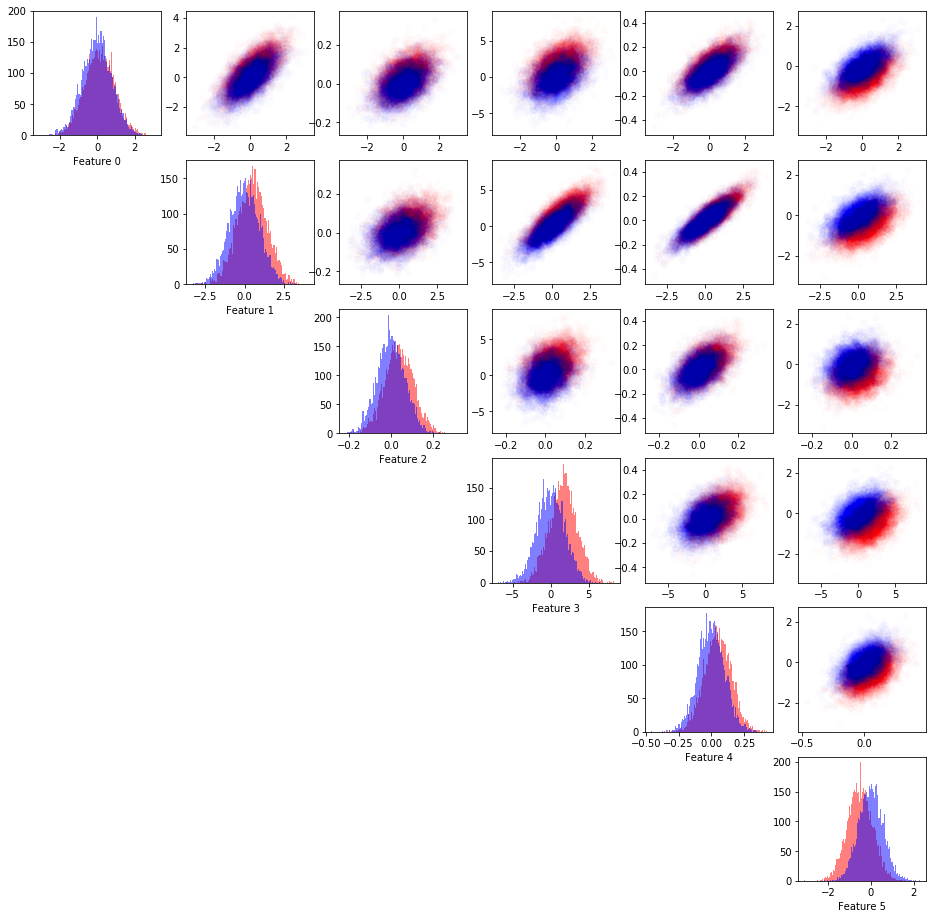

In [4]:
fig, ax = plt.subplots(num_features, num_features, figsize=(16,16))
for i in range(num_features):
    for j in range(num_features):
        if j < i: 
            ax[i][j].axis('off')
            continue
        if i == j:
            ax[i][j].hist(sig[:,i], bins=100,   alpha=0.5, color='red')
            ax[i][j].hist(bkg[:,i], bins=100,   alpha=0.5, color='blue')
            ax[i][j].set_xlabel('Feature {}'.format(i))
        else:
            ax[i][j].scatter(sig[:,i], sig[:,j], alpha=0.01, color='red')
            ax[i][j].scatter(bkg[:,i], bkg[:,j], alpha=0.01, color='blue')
        pass
    pass
plt.show()

### Shuffle, split datasets into training- and test arrays

In [5]:
# Shuffle
idx = np.arange(y.size)
rng.shuffle(idx)

X  = X [idx,:]
X1 = X1[idx,:]
X2 = X2[idx,:]
y  = y [idx]

# Split into training and test
num_train = int(0.8 * y.size)

X1_train = X1[:num_train,:]
X2_train = X2[:num_train,:]
y_train  = y [:num_train]

X1_test = X1[num_train:,:]
X2_test = X2[num_train:,:]
y_test  = y [num_train:]

### Plot covariance matix

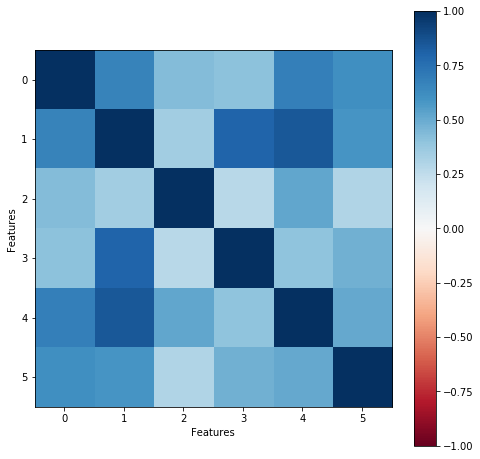

In [6]:
corr_ = np.corrcoef(bkg.T)
fig, ax = plt.subplots(figsize=(8,8))

plt.imshow(corr_, vmin=-1, vmax=1, cmap='RdBu')
plt.xlabel('Features')
plt.ylabel('Features')
plt.colorbar()
plt.show()

## Standalone classifiers
---
Create, compile, and train neural network models

In [7]:
# Network architecture
arch_clf = [{"units": 16, "activation": "relu"}] * 3

# Create networks
clf1 = classifier_model(num_features_per_class, arch_clf, scope='clf1')
clf2 = classifier_model(num_features_per_class, arch_clf, scope='clf2')

# Compile
clf1.compile(loss='binary_crossentropy', optimizer='adam')
clf2.compile(loss='binary_crossentropy', optimizer='adam')

# Train
ret1 = clf1.fit(X1_train, y_train, shuffle=True, epochs=30, validation_split=0.2, batch_size=128)
ret2 = clf2.fit(X2_train, y_train, shuffle=True, epochs=30, validation_split=0.2, batch_size=128)

Train on 6400 samples, validate on 1600 samples
Epoch 1/30
6400/6400 [==============================] - 1s 104us/step - loss: 0.7447 - val_loss: 0.6834
Epoch 2/30
6400/6400 [==============================] - 0s 14us/step - loss: 0.6612 - val_loss: 0.6843
Epoch 3/30
6400/6400 [==============================] - 0s 14us/step - loss: 0.6496 - val_loss: 0.6856
Epoch 4/30
6400/6400 [==============================] - 0s 14us/step - loss: 0.6432 - val_loss: 0.6821
Epoch 5/30
6400/6400 [==============================] - 0s 14us/step - loss: 0.6380 - val_loss: 0.6805
Epoch 6/30
6400/6400 [==============================] - 0s 13us/step - loss: 0.6355 - val_loss: 0.6741
Epoch 7/30
6400/6400 [==============================] - 0s 14us/step - loss: 0.6309 - val_loss: 0.6677
Epoch 8/30
6400/6400 [==============================] - 0s 15us/step - loss: 0.6298 - val_loss: 0.6615
Epoch 9/30
6400/6400 [==============================] - 0s 14us/step - loss: 0.6290 - val_loss: 0.6558
Epoch 10/30
6400/6400 [=

### Plot classifier losses

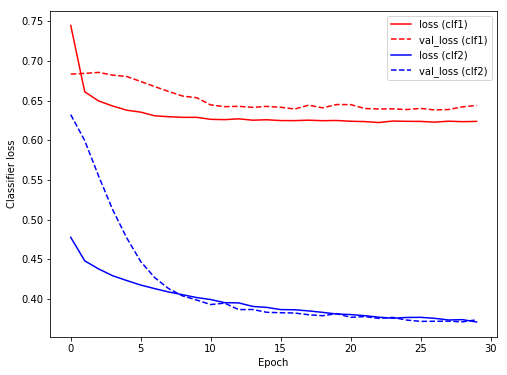

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
colors=['red', 'blue']
linestyles=['-','--',':']
for idx, ret in enumerate([ret1, ret2]):
    for jdx, (name, loss) in enumerate(ret.history.iteritems()):
        plt.plot(loss, color=colors[idx], linestyle=linestyles[jdx], label='{} (clf{})'.format(name, idx + 1))
        pass
    pass
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Classifier loss')
plt.show()

### Plot correlations between classifier predictions  

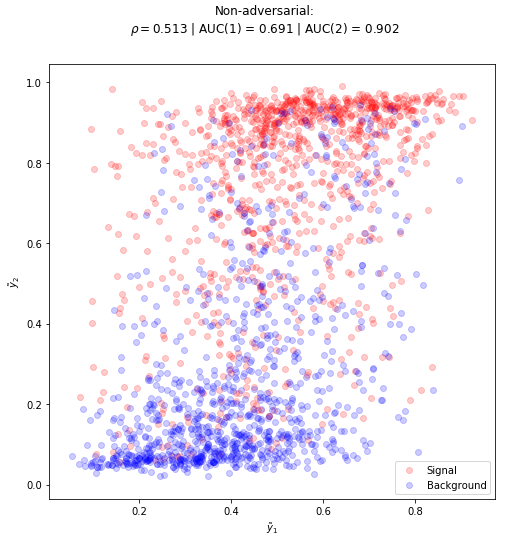

In [9]:
# Get classifier preductions
pred1_test = clf1.predict(X1_test)
pred2_test = clf2.predict(X2_test)

# Compute correlation and ROC AUC
rho = np.corrcoef(np.hstack((pred1_test, pred2_test)).T)[0,1]
auc1 = roc_auc_score(y_test, pred1_test)
auc2 = roc_auc_score(y_test, pred2_test)

# Plot correlation
msk = (y_test == 1)
fig, ax = plt.subplots(figsize=(8,8))
plt.suptitle('Non-adversarial:\n' + r'$\rho = {:.3f}$ | AUC(1) = {:.3f} | AUC(2) = {:.3f}'.format(rho, auc1, auc2))
plt.scatter(pred1_test[ msk], pred2_test[ msk], alpha=0.2, color='red',  label='Signal')
plt.scatter(pred1_test[~msk], pred2_test[~msk], alpha=0.2, color='blue', label='Background')
plt.xlabel(r'$\tilde{y}_{1}$')
plt.ylabel(r'$\tilde{y}_{2}$')
plt.legend()
plt.show()

### Plot classifier distributions

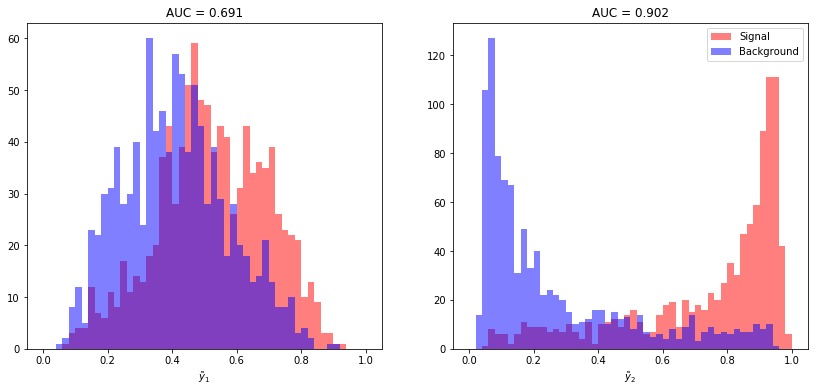

In [10]:
msk = (y_test == 1)
bins = np.linspace(0, 1, 50 + 1, endpoint=True)

fig, ax = plt.subplots(1,2, figsize=(14,6))

# Classifier 1
ax[0].set_title('AUC = {:.3f}'.format(auc1))
ax[0].hist(pred1_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[0].hist(pred1_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[0].set_xlabel(r'$\tilde{y}_{1}$')

# Classifier 2
ax[1].set_title('AUC = {:.3f}'.format(auc2))
ax[1].hist(pred2_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[1].hist(pred2_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[1].set_xlabel(r'$\tilde{y}_{2}$')

plt.legend()
plt.show()

## Decorrelated classifiers
___

Define custom decorrelation layer.

In [11]:
def correlation_coefficient (x, y):
    """
    Compute the linear correlation coefficient for input arrays `x` and `y` 
    using Keras backend methods.
    """
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

class DecorrelationLayer (Layer):
    """
    Custom Keras layer, outputting the linear correlation coefficient for the 
    outputs from the previous layers.
    """
    def __init__ (self, **kwargs):
        super(DecorrelationLayer, self).__init__(**kwargs)
        pass

    def build (self, input_shape):
        return

    def call (self, x, mask=None):
        assert isinstance(x, list)
        assert len(x) == 2
        return correlation_coefficient(*x)

    def compute_output_shape (self, input_shape):
        return input_shape[:1]  # (None,)

    pass



class LossRatioLayer (Layer):
    """
    Custom Keras layer, outputting the ratio of losses of the outputs from the 
    previous layers.
    """
    def __init__ (self, loss, **kwargs):
        super(LossRatioLayer, self).__init__(**kwargs)
        assert isinstance(loss, list)
        assert len(loss) == 2
        self._loss = loss
        pass

    def build (self, input_shape):
        return

    def call (self, x, mask=None):
        assert isinstance(x, list)
        assert len(x) == 4
        # x = [pred_0, pred_1, targetr_0, target_1]
        return K.mean(self._loss[0](K.flatten(x[0]), K.flatten(x[2])) / self._loss[1](K.flatten(x[1]), K.flatten(x[3])))

    def compute_output_shape (self, input_shape):
        return input_shape[:1]  # (None,)

    pass



Define custom `Decorrelator` model.

In [12]:
# @TODO: 
# - Balance gradients/losses?
# - Optimise joint loss? (Reduces generality...)
class Decorrelator (object):

    def __init__ (self, clf1, clf2, lambda_reg=100., beta_reg=10.):
        """
        ...
        """
    
        # Check(s)
        # ...
        
        self._clf1 = clf1
        self._clf2 = clf2
        
        self._lambda = lambda_reg
        self._beta   = beta_reg

        self._targets = None
        self._loss    = None
        self._model   = None
        return
    
    def _build (self):
        """
        ...
        """
        
        # Reconstruct classifier
        input_clf1 = Input(shape=self._clf1.layers[0].input_shape[1:])
        input_clf2 = Input(shape=self._clf2.layers[0].input_shape[1:])
        
        output_clf1 = self._clf1(input_clf1)
        output_clf2 = self._clf2(input_clf2)
        
        # Target inputs, for balancing
        target_clf1 = Input(shape=self._clf1.layers[-1].output_shape[1:])
        target_clf2 = Input(shape=self._clf2.layers[-1].output_shape[1:])
        
        # Add decorrelation layer
        corr = DecorrelationLayer()([output_clf1, output_clf2])
        
        # Add balance layer
        balance = LossRatioLayer(loss=self._loss)([output_clf1, output_clf2, target_clf1, target_clf2])

        # Build model
        self._model = Model(inputs =[input_clf1,  input_clf2, target_clf1, target_clf2],
                            outputs=[output_clf1, output_clf2, corr, balance],
                            name='decorrelator')
        return

    
    def compile (self, loss, **kwargs):
        """
        ...
        """
        
        # Check(s)
        if not isinstance(loss, list):
            loss = list(loss)
            pass
        self._loss = [keras.losses.get(l) for l in loss]

        # Internal build method
        self._build()

        # Compile underlying model
        self._model.compile(loss=self._loss + ['MSE', 'MSE'], loss_weights=[1., 1., self._lambda, self._beta], **kwargs)
        return

    
    def fit (self, inputs, targets, **kwargs):
        """
        ...
        """
        
        # Check(s)
        if not isinstance(targets, list):
            targets = list(targets)
            pass
        self._targets = targets
        self._inputs  = inputs

        # Compute target loss ratio
        # @TODO: Use loss functions!
        loss_num = self._clf1.evaluate(self._inputs[0], self._targets[0])
        loss_den = self._clf2.evaluate(self._inputs[1], self._targets[1])
        loss_ratio = np.ones((self._targets[0].shape[0],)) * loss_num / loss_den
        print "TARGET RATIO: {} / {} = {}".format(loss_num, loss_den, loss_ratio[0])
        
        # Actual fit method
        zeros = np.zeros((self._targets[0].shape[0],))
        return self._model.fit(self._inputs + self._targets, self._targets + [zeros, loss_ratio], **kwargs)
        
    pass
    

Create `Decorrelator` instance.

In [13]:
decorr = Decorrelator(clf1, clf2, lambda_reg=1.0E+03, beta_reg=1.0E+04)

# Define optimiser.
adam = Adam(lr=1.0E-05)

# Compile
decorr.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=adam)

Visualise the network models.

In [14]:
plot_model(clf1, to_file='figures/classifier.png', show_shapes=True)
plot_model(decorr._model, to_file='figures/decorrelator.png', show_shapes=True)

### Classifier model

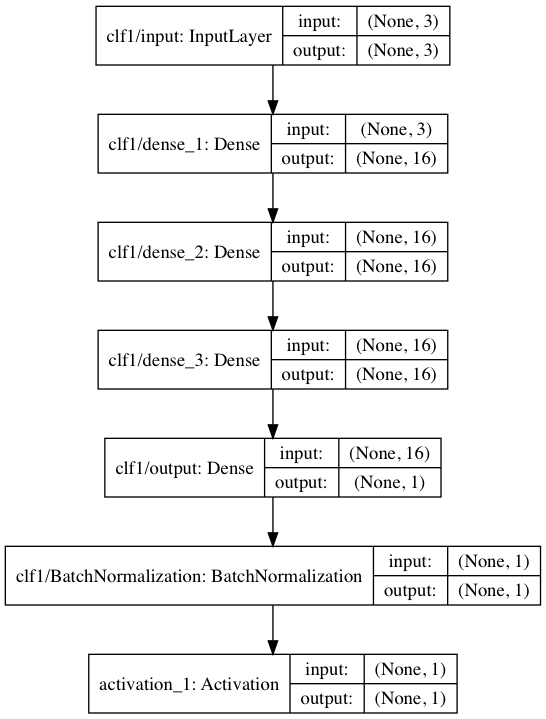

In [15]:
Image(filename='figures/classifier.png')

### `Decorrelator` model

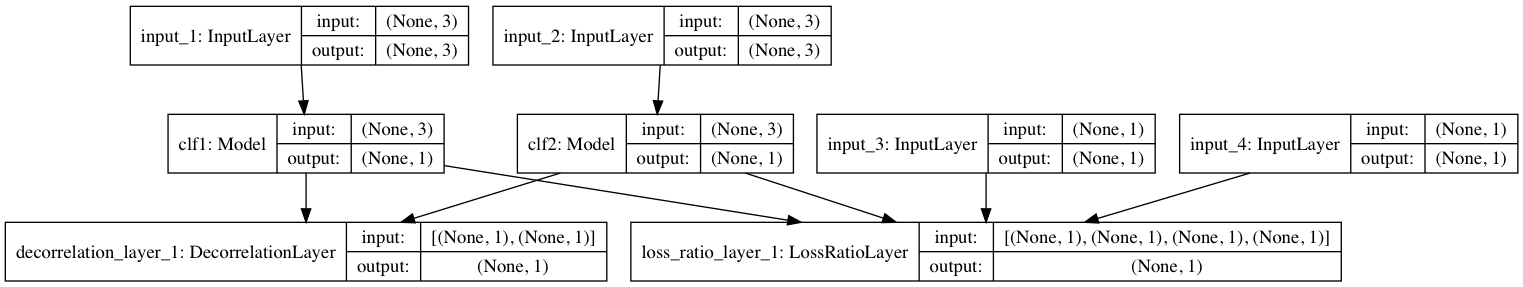

In [16]:
Image(filename='figures/decorrelator.png')

Define optimiser, compile and train `Decorrelator`.

In [17]:
# Fit
ret = decorr.fit([X1_train, X2_train], [y_train, y_train], shuffle=True, epochs=30 * 10, validation_split=0.2, batch_size=128)

8000/8000 [==============================] - 0s 16us/step
TARGET RATIO: 0.62859296751 / 0.370078715444 = 1.69853855755
Train on 6400 samples, validate on 1600 samples
Epoch 1/300
6400/6400 [==============================] - 2s 246us/step - loss: 456.7866 - clf1_loss: 0.6228 - clf2_loss: 0.3713 - decorrelation_layer_1_loss: 0.2779 - loss_ratio_layer_1_loss: 0.0178 - val_loss: 547.9496 - val_clf1_loss: 0.6439 - val_clf2_loss: 0.3734 - val_decorrelation_layer_1_loss: 0.2495 - val_loss_ratio_layer_1_loss: 0.0297
Epoch 2/300
6400/6400 [==============================] - 0s 30us/step - loss: 400.7719 - clf1_loss: 0.6227 - clf2_loss: 0.3721 - decorrelation_layer_1_loss: 0.2714 - loss_ratio_layer_1_loss: 0.0128 - val_loss: 538.3156 - val_clf1_loss: 0.6443 - val_clf2_loss: 0.3731 - val_decorrelation_layer_1_loss: 0.2426 - val_loss_ratio_layer_1_loss: 0.0295
Epoch 3/300
6400/6400 [==============================] - 0s 30us/step - loss: 414.0490 - clf1_loss: 0.6237 - clf2_loss: 0.3729 - decorrelati

Epoch 24/300
6400/6400 [==============================] - 0s 30us/step - loss: 236.8810 - clf1_loss: 0.6424 - clf2_loss: 0.3949 - decorrelation_layer_1_loss: 0.1021 - loss_ratio_layer_1_loss: 0.0134 - val_loss: 307.1803 - val_clf1_loss: 0.6663 - val_clf2_loss: 0.3876 - val_decorrelation_layer_1_loss: 0.0849 - val_loss_ratio_layer_1_loss: 0.0221
Epoch 25/300
6400/6400 [==============================] - 0s 30us/step - loss: 216.8219 - clf1_loss: 0.6421 - clf2_loss: 0.3947 - decorrelation_layer_1_loss: 0.0967 - loss_ratio_layer_1_loss: 0.0119 - val_loss: 300.7821 - val_clf1_loss: 0.6670 - val_clf2_loss: 0.3885 - val_decorrelation_layer_1_loss: 0.0810 - val_loss_ratio_layer_1_loss: 0.0219
Epoch 26/300
6400/6400 [==============================] - 0s 30us/step - loss: 329.4380 - clf1_loss: 0.6432 - clf2_loss: 0.3958 - decorrelation_layer_1_loss: 0.0910 - loss_ratio_layer_1_loss: 0.0237 - val_loss: 298.0511 - val_clf1_loss: 0.6671 - val_clf2_loss: 0.3890 - val_decorrelation_layer_1_loss: 0.07

6400/6400 [==============================] - 0s 30us/step - loss: 304.3543 - clf1_loss: 0.6569 - clf2_loss: 0.4055 - decorrelation_layer_1_loss: 0.0485 - loss_ratio_layer_1_loss: 0.0255 - val_loss: 258.9480 - val_clf1_loss: 0.6800 - val_clf2_loss: 0.3967 - val_decorrelation_layer_1_loss: 0.0427 - val_loss_ratio_layer_1_loss: 0.0215
Epoch 48/300
6400/6400 [==============================] - 0s 30us/step - loss: 357.7658 - clf1_loss: 0.6567 - clf2_loss: 0.4060 - decorrelation_layer_1_loss: 0.0494 - loss_ratio_layer_1_loss: 0.0307 - val_loss: 259.0877 - val_clf1_loss: 0.6795 - val_clf2_loss: 0.3967 - val_decorrelation_layer_1_loss: 0.0428 - val_loss_ratio_layer_1_loss: 0.0215
Epoch 49/300
6400/6400 [==============================] - 0s 29us/step - loss: 274.7693 - clf1_loss: 0.6566 - clf2_loss: 0.4051 - decorrelation_layer_1_loss: 0.0506 - loss_ratio_layer_1_loss: 0.0223 - val_loss: 260.0734 - val_clf1_loss: 0.6800 - val_clf2_loss: 0.3966 - val_decorrelation_layer_1_loss: 0.0422 - val_loss

Epoch 71/300
6400/6400 [==============================] - 0s 41us/step - loss: 185.5131 - clf1_loss: 0.6651 - clf2_loss: 0.4077 - decorrelation_layer_1_loss: 0.0342 - loss_ratio_layer_1_loss: 0.0150 - val_loss: 249.2188 - val_clf1_loss: 0.6877 - val_clf2_loss: 0.3986 - val_decorrelation_layer_1_loss: 0.0308 - val_loss_ratio_layer_1_loss: 0.0217
Epoch 72/300
6400/6400 [==============================] - 0s 30us/step - loss: 221.6913 - clf1_loss: 0.6656 - clf2_loss: 0.4092 - decorrelation_layer_1_loss: 0.0347 - loss_ratio_layer_1_loss: 0.0186 - val_loss: 251.7648 - val_clf1_loss: 0.6875 - val_clf2_loss: 0.3985 - val_decorrelation_layer_1_loss: 0.0308 - val_loss_ratio_layer_1_loss: 0.0220
Epoch 73/300
6400/6400 [==============================] - 0s 36us/step - loss: 223.4961 - clf1_loss: 0.6644 - clf2_loss: 0.4085 - decorrelation_layer_1_loss: 0.0349 - loss_ratio_layer_1_loss: 0.0188 - val_loss: 252.0489 - val_clf1_loss: 0.6879 - val_clf2_loss: 0.3984 - val_decorrelation_layer_1_loss: 0.03

Epoch 94/300
6400/6400 [==============================] - 0s 33us/step - loss: 159.4741 - clf1_loss: 0.6699 - clf2_loss: 0.4081 - decorrelation_layer_1_loss: 0.0275 - loss_ratio_layer_1_loss: 0.0131 - val_loss: 244.0469 - val_clf1_loss: 0.6916 - val_clf2_loss: 0.3996 - val_decorrelation_layer_1_loss: 0.0254 - val_loss_ratio_layer_1_loss: 0.0218
Epoch 95/300
6400/6400 [==============================] - 0s 35us/step - loss: 251.0373 - clf1_loss: 0.6704 - clf2_loss: 0.4106 - decorrelation_layer_1_loss: 0.0299 - loss_ratio_layer_1_loss: 0.0220 - val_loss: 244.0991 - val_clf1_loss: 0.6917 - val_clf2_loss: 0.3994 - val_decorrelation_layer_1_loss: 0.0255 - val_loss_ratio_layer_1_loss: 0.0218
Epoch 96/300
6400/6400 [==============================] - 0s 34us/step - loss: 192.6396 - clf1_loss: 0.6699 - clf2_loss: 0.4081 - decorrelation_layer_1_loss: 0.0270 - loss_ratio_layer_1_loss: 0.0165 - val_loss: 244.5617 - val_clf1_loss: 0.6919 - val_clf2_loss: 0.3994 - val_decorrelation_layer_1_loss: 0.02

6400/6400 [==============================] - 0s 30us/step - loss: 209.4452 - clf1_loss: 0.6751 - clf2_loss: 0.4112 - decorrelation_layer_1_loss: 0.0257 - loss_ratio_layer_1_loss: 0.0183 - val_loss: 239.7826 - val_clf1_loss: 0.6948 - val_clf2_loss: 0.4002 - val_decorrelation_layer_1_loss: 0.0222 - val_loss_ratio_layer_1_loss: 0.0217
Epoch 118/300
6400/6400 [==============================] - 0s 29us/step - loss: 203.1367 - clf1_loss: 0.6743 - clf2_loss: 0.4111 - decorrelation_layer_1_loss: 0.0234 - loss_ratio_layer_1_loss: 0.0179 - val_loss: 239.4632 - val_clf1_loss: 0.6952 - val_clf2_loss: 0.4001 - val_decorrelation_layer_1_loss: 0.0220 - val_loss_ratio_layer_1_loss: 0.0216
Epoch 119/300
6400/6400 [==============================] - 0s 31us/step - loss: 245.9959 - clf1_loss: 0.6753 - clf2_loss: 0.4105 - decorrelation_layer_1_loss: 0.0228 - loss_ratio_layer_1_loss: 0.0222 - val_loss: 238.8272 - val_clf1_loss: 0.6952 - val_clf2_loss: 0.4001 - val_decorrelation_layer_1_loss: 0.0220 - val_lo

Epoch 141/300
6400/6400 [==============================] - 0s 34us/step - loss: 147.2490 - clf1_loss: 0.6766 - clf2_loss: 0.4084 - decorrelation_layer_1_loss: 0.0201 - loss_ratio_layer_1_loss: 0.0126 - val_loss: 237.0126 - val_clf1_loss: 0.6979 - val_clf2_loss: 0.3999 - val_decorrelation_layer_1_loss: 0.0201 - val_loss_ratio_layer_1_loss: 0.0216
Epoch 142/300
6400/6400 [==============================] - 0s 32us/step - loss: 171.6027 - clf1_loss: 0.6790 - clf2_loss: 0.4109 - decorrelation_layer_1_loss: 0.0205 - loss_ratio_layer_1_loss: 0.0150 - val_loss: 235.4638 - val_clf1_loss: 0.6981 - val_clf2_loss: 0.4002 - val_decorrelation_layer_1_loss: 0.0199 - val_loss_ratio_layer_1_loss: 0.0214
Epoch 143/300
6400/6400 [==============================] - 0s 29us/step - loss: 272.8310 - clf1_loss: 0.6780 - clf2_loss: 0.4092 - decorrelation_layer_1_loss: 0.0255 - loss_ratio_layer_1_loss: 0.0246 - val_loss: 237.8700 - val_clf1_loss: 0.6981 - val_clf2_loss: 0.3997 - val_decorrelation_layer_1_loss: 0

6400/6400 [==============================] - 0s 30us/step - loss: 190.8879 - clf1_loss: 0.6795 - clf2_loss: 0.4091 - decorrelation_layer_1_loss: 0.0185 - loss_ratio_layer_1_loss: 0.0171 - val_loss: 231.4926 - val_clf1_loss: 0.6995 - val_clf2_loss: 0.4002 - val_decorrelation_layer_1_loss: 0.0185 - val_loss_ratio_layer_1_loss: 0.0212
Epoch 165/300
6400/6400 [==============================] - 0s 30us/step - loss: 192.8946 - clf1_loss: 0.6798 - clf2_loss: 0.4092 - decorrelation_layer_1_loss: 0.0200 - loss_ratio_layer_1_loss: 0.0172 - val_loss: 229.8009 - val_clf1_loss: 0.6997 - val_clf2_loss: 0.4005 - val_decorrelation_layer_1_loss: 0.0184 - val_loss_ratio_layer_1_loss: 0.0210
Epoch 166/300
6400/6400 [==============================] - 0s 31us/step - loss: 190.0185 - clf1_loss: 0.6798 - clf2_loss: 0.4102 - decorrelation_layer_1_loss: 0.0191 - loss_ratio_layer_1_loss: 0.0170 - val_loss: 230.4804 - val_clf1_loss: 0.6997 - val_clf2_loss: 0.4003 - val_decorrelation_layer_1_loss: 0.0185 - val_lo

Epoch 188/300
6400/6400 [==============================] - 0s 32us/step - loss: 152.5754 - clf1_loss: 0.6819 - clf2_loss: 0.4104 - decorrelation_layer_1_loss: 0.0168 - loss_ratio_layer_1_loss: 0.0135 - val_loss: 230.9534 - val_clf1_loss: 0.7016 - val_clf2_loss: 0.3999 - val_decorrelation_layer_1_loss: 0.0173 - val_loss_ratio_layer_1_loss: 0.0213
Epoch 189/300
6400/6400 [==============================] - 0s 34us/step - loss: 126.9396 - clf1_loss: 0.6816 - clf2_loss: 0.4101 - decorrelation_layer_1_loss: 0.0192 - loss_ratio_layer_1_loss: 0.0107 - val_loss: 227.5161 - val_clf1_loss: 0.7018 - val_clf2_loss: 0.4004 - val_decorrelation_layer_1_loss: 0.0171 - val_loss_ratio_layer_1_loss: 0.0209
Epoch 190/300
6400/6400 [==============================] - 0s 32us/step - loss: 211.3705 - clf1_loss: 0.6817 - clf2_loss: 0.4097 - decorrelation_layer_1_loss: 0.0156 - loss_ratio_layer_1_loss: 0.0195 - val_loss: 226.8011 - val_clf1_loss: 0.7019 - val_clf2_loss: 0.4003 - val_decorrelation_layer_1_loss: 0

6400/6400 [==============================] - 0s 32us/step - loss: 197.5715 - clf1_loss: 0.6844 - clf2_loss: 0.4105 - decorrelation_layer_1_loss: 0.0177 - loss_ratio_layer_1_loss: 0.0179 - val_loss: 225.1398 - val_clf1_loss: 0.7029 - val_clf2_loss: 0.4000 - val_decorrelation_layer_1_loss: 0.0164 - val_loss_ratio_layer_1_loss: 0.0208
Epoch 212/300
6400/6400 [==============================] - 0s 33us/step - loss: 209.9668 - clf1_loss: 0.6842 - clf2_loss: 0.4101 - decorrelation_layer_1_loss: 0.0147 - loss_ratio_layer_1_loss: 0.0194 - val_loss: 223.2420 - val_clf1_loss: 0.7030 - val_clf2_loss: 0.4002 - val_decorrelation_layer_1_loss: 0.0164 - val_loss_ratio_layer_1_loss: 0.0206
Epoch 213/300
6400/6400 [==============================] - 0s 33us/step - loss: 159.7086 - clf1_loss: 0.6848 - clf2_loss: 0.4085 - decorrelation_layer_1_loss: 0.0156 - loss_ratio_layer_1_loss: 0.0143 - val_loss: 225.1365 - val_clf1_loss: 0.7033 - val_clf2_loss: 0.4001 - val_decorrelation_layer_1_loss: 0.0164 - val_lo

Epoch 235/300
6400/6400 [==============================] - 0s 51us/step - loss: 193.1433 - clf1_loss: 0.6860 - clf2_loss: 0.4102 - decorrelation_layer_1_loss: 0.0174 - loss_ratio_layer_1_loss: 0.0175 - val_loss: 216.3447 - val_clf1_loss: 0.7043 - val_clf2_loss: 0.4005 - val_decorrelation_layer_1_loss: 0.0156 - val_loss_ratio_layer_1_loss: 0.0200
Epoch 236/300
6400/6400 [==============================] - 0s 45us/step - loss: 204.1605 - clf1_loss: 0.6858 - clf2_loss: 0.4097 - decorrelation_layer_1_loss: 0.0199 - loss_ratio_layer_1_loss: 0.0183 - val_loss: 218.1919 - val_clf1_loss: 0.7044 - val_clf2_loss: 0.4003 - val_decorrelation_layer_1_loss: 0.0156 - val_loss_ratio_layer_1_loss: 0.0201
Epoch 237/300
6400/6400 [==============================] - 0s 44us/step - loss: 123.5198 - clf1_loss: 0.6861 - clf2_loss: 0.4115 - decorrelation_layer_1_loss: 0.0146 - loss_ratio_layer_1_loss: 0.0108 - val_loss: 218.5658 - val_clf1_loss: 0.7047 - val_clf2_loss: 0.4003 - val_decorrelation_layer_1_loss: 0

6400/6400 [==============================] - 0s 35us/step - loss: 202.6594 - clf1_loss: 0.6872 - clf2_loss: 0.4074 - decorrelation_layer_1_loss: 0.0164 - loss_ratio_layer_1_loss: 0.0185 - val_loss: 220.1657 - val_clf1_loss: 0.7054 - val_clf2_loss: 0.3987 - val_decorrelation_layer_1_loss: 0.0156 - val_loss_ratio_layer_1_loss: 0.0203
Epoch 259/300
6400/6400 [==============================] - 0s 38us/step - loss: 196.3552 - clf1_loss: 0.6874 - clf2_loss: 0.4069 - decorrelation_layer_1_loss: 0.0153 - loss_ratio_layer_1_loss: 0.0180 - val_loss: 217.5792 - val_clf1_loss: 0.7051 - val_clf2_loss: 0.3990 - val_decorrelation_layer_1_loss: 0.0156 - val_loss_ratio_layer_1_loss: 0.0201
Epoch 260/300
6400/6400 [==============================] - 0s 40us/step - loss: 151.5550 - clf1_loss: 0.6872 - clf2_loss: 0.4095 - decorrelation_layer_1_loss: 0.0152 - loss_ratio_layer_1_loss: 0.0135 - val_loss: 218.8139 - val_clf1_loss: 0.7051 - val_clf2_loss: 0.3990 - val_decorrelation_layer_1_loss: 0.0155 - val_lo

Epoch 282/300
6400/6400 [==============================] - 0s 32us/step - loss: 198.3422 - clf1_loss: 0.6880 - clf2_loss: 0.4075 - decorrelation_layer_1_loss: 0.0155 - loss_ratio_layer_1_loss: 0.0182 - val_loss: 212.8421 - val_clf1_loss: 0.7062 - val_clf2_loss: 0.3990 - val_decorrelation_layer_1_loss: 0.0148 - val_loss_ratio_layer_1_loss: 0.0197
Epoch 283/300
6400/6400 [==============================] - 0s 33us/step - loss: 222.5602 - clf1_loss: 0.6886 - clf2_loss: 0.4097 - decorrelation_layer_1_loss: 0.0146 - loss_ratio_layer_1_loss: 0.0207 - val_loss: 213.2713 - val_clf1_loss: 0.7060 - val_clf2_loss: 0.3989 - val_decorrelation_layer_1_loss: 0.0148 - val_loss_ratio_layer_1_loss: 0.0197
Epoch 284/300
6400/6400 [==============================] - 0s 35us/step - loss: 182.6144 - clf1_loss: 0.6872 - clf2_loss: 0.4074 - decorrelation_layer_1_loss: 0.0122 - loss_ratio_layer_1_loss: 0.0169 - val_loss: 213.6936 - val_clf1_loss: 0.7059 - val_clf2_loss: 0.3988 - val_decorrelation_layer_1_loss: 0

### Plot `Decorrelator` training loss

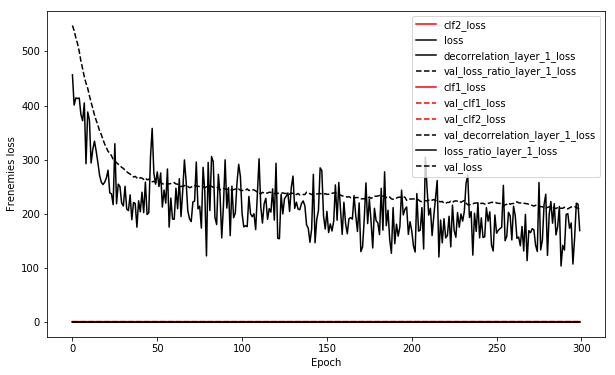

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
for idx, (name, loss) in enumerate(ret.history.iteritems()):
    color='red' if 'clf' in name else ('blue' if 'adv' in name else 'black')
    linestyle='--' if 'val' in name else '-'
    plt.plot(loss, color=color, linestyle=linestyle, label=name)
    pass
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Frenemies loss')
plt.show()

### Plot correlations between classifier predictions

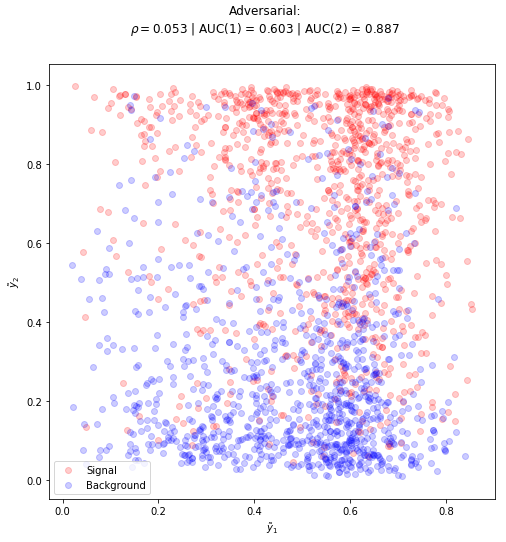

In [19]:
# Get classifier preditions
pred1_test = clf1.predict(X1_test)
pred2_test = clf2.predict(X2_test)

# Compute correlation and ROC AUC
rho = np.corrcoef(np.hstack((pred1_test, pred2_test)).T)[0,1]
auc1 = roc_auc_score(y_test, pred1_test)
auc2 = roc_auc_score(y_test, pred2_test)

# Plot correlation
msk = (y_test == 1)
fig, ax = plt.subplots(figsize=(8,8))
plt.suptitle('Adversarial:\n' + r'$\rho = {:.3f}$ | AUC(1) = {:.3f} | AUC(2) = {:.3f}'.format(rho, auc1, auc2))
plt.scatter(pred1_test[ msk], pred2_test[ msk], alpha=0.2, color='red',  label='Signal')
plt.scatter(pred1_test[~msk], pred2_test[~msk], alpha=0.2, color='blue', label='Background')
plt.xlabel(r'$\tilde{y}_{1}$')
plt.ylabel(r'$\tilde{y}_{2}$')
plt.legend()
plt.show()

### Plot classifier distributions

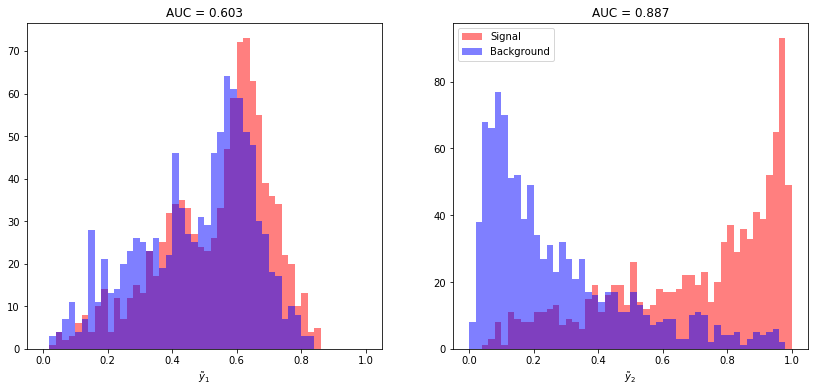

In [20]:
msk = (y_test == 1)
bins = np.linspace(0, 1, 50 + 1, endpoint=True)

fig, ax = plt.subplots(1,2, figsize=(14,6))

# Classifier 1
ax[0].set_title('AUC = {:.3f}'.format(auc1))
ax[0].hist(pred1_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[0].hist(pred1_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[0].set_xlabel(r'$\tilde{y}_{1}$')

# Classifier 2
ax[1].set_title('AUC = {:.3f}'.format(auc2))
ax[1].hist(pred2_test[ msk], bins=bins, alpha=0.5, color='red',  label='Signal')
ax[1].hist(pred2_test[~msk], bins=bins, alpha=0.5, color='blue', label='Background')
ax[1].set_xlabel(r'$\tilde{y}_{2}$')

plt.legend()
plt.show()